<a href="https://colab.research.google.com/github/manishiitg/ML_Experiments/blob/master/autoencoder/VAE_Experiment_with_Face_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE Autoencoder Feed Forward Network

VAE Auto encoder on celeba data set 

In [1]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# Next, install the Kaggle API client.
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 66 Nov 12 07:52 kaggle.json


In [2]:
# !kaggle datasets download -d ashishpatel26/indian-movie-face-database-imfdb
datasetname = "celeba-dataset"
!kaggle datasets download -d jessicali9530/celeba-dataset

celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import zipfile

with zipfile.ZipFile("./" + datasetname  + ".zip","r") as zip_ref:
  zip_ref.extractall(datasetname)

Above, download data set from kaggle. 

In [4]:
import os
root = './' + datasetname + '/img_align_celeba/img_align_celeba'
img_list = os.listdir(root)
print(img_list[:10])
print(len(img_list))

['178241.jpg', '197806.jpg', '145006.jpg', '063694.jpg', '137139.jpg', '118467.jpg', '122762.jpg', '126971.jpg', '108310.jpg', '015369.jpg']
202599


Just to see if images exists 

In [5]:
import torch
import torch.nn as nn
import torchvision  
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader


import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
import PIL.Image as Image


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.ToPILImage(),
     transforms.Resize(size=(64, 64), interpolation=Image.BICUBIC),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)])

batch_size = 256
celeba_data = datasets.ImageFolder('./' + datasetname, transform=transform)
dataset_len = 100000
data_loader = DataLoader(celeba_data,batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(list(range(dataset_len))))


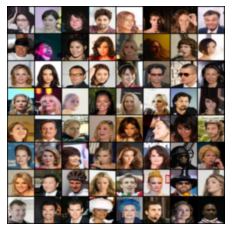

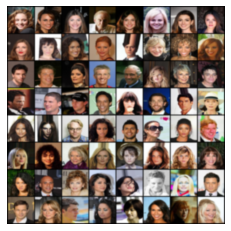

In [7]:
def show(img,renorm=False,nrow=8,interpolation='bicubic'):
  if renorm:
    img = img/2 + 0.5
  img_grid = torchvision.utils.make_grid(img,nrow=nrow).numpy()
  plt.figure()
  plt.imshow(np.transpose(img_grid, (1,2,0)), interpolation=interpolation)
  plt.axis('off')
  plt.show()

batch, _ = next(iter(data_loader))
show(batch[0:64], renorm = True, nrow=8)
show(batch[64:128], renorm = True, nrow=8)

Previewing the data 

In [0]:
class VAE(nn.Module):
    def __init__(self, nc, ndf, ngf, z_dim=150):
        super(VAE, self).__init__()
        h_dim = nc * ndf * ngf
        self.nc = nc
        self.ndf = ndf
        self.ngf = ngf
        self.h_dim = h_dim
        self.encoder = nn.Sequential(
            nn.Linear(h_dim, 2000),
            nn.ReLU(),
            nn.Linear(2000, 500),
            nn.ReLU(),
            nn.Linear(500, 100),
            nn.ReLU()
        )   
        
        self.fc1 = nn.Linear(100, z_dim)
        self.fc2 = nn.Linear(100, z_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 500),
            nn.ReLU(),
            nn.Linear(500, 2000),
            nn.ReLU(),
            nn.Linear(2000, h_dim),
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_().to(device)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        # print("encoder input shape" , x.shape)
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.decoder(z)
        return z

    def forward(self, x):
        
        # print(x.shape, "input shape")
        x = x.view(-1, self.nc * self.ndf * self.ngf)
        # print("reshape", x.shape)
        z, mu, logvar = self.encode(x)
        # print("resampleing" , z.shape)
        z = self.decode(z)
        # print(z.shape, "output shape")
        z = z.view(-1, self.nc, self.ndf , self.ngf )
        return z, mu, logvar


batch, _ = next(iter(data_loader))
img = batch[1]

channels = img.size(0)
w, h = img.size(1) , img.size(2) 

nc = channels
ndf = w
ngf = h

model = VAE(nc=nc, ngf=ngf, ndf=ndf).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=.0005)

def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


In [0]:
def train(epoch):
    model.train()
    train_loss = 0
    count_data = 0
    batch_count_data = 0
    for batch_idx, (data, _) in enumerate(data_loader):
        # print(batch_idx)
        count_data += len(data)
        batch_count_data += len(data)
        images = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(images)
        loss = loss_fn(recon_batch, images, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), dataset_len,
                100. * batch_idx / len(data_loader), loss.item() / batch_count_data))
            batch_count_data = 0
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / count_data))



Setting up the model

In [10]:
for i in range(50):
  train(i)

Train Epoch: 0 [0/100000 (0%)]	Loss: 8521.380859
Train Epoch: 0 [2560/100000 (3%)]	Loss: -5409.062891
Train Epoch: 0 [5120/100000 (5%)]	Loss: -7084.942969
Train Epoch: 0 [7680/100000 (8%)]	Loss: -9471.921875
Train Epoch: 0 [10240/100000 (10%)]	Loss: -9879.845312
Train Epoch: 0 [12800/100000 (13%)]	Loss: -8805.605469
Train Epoch: 0 [15360/100000 (15%)]	Loss: -11231.578906
Train Epoch: 0 [17920/100000 (18%)]	Loss: -11479.396875
Train Epoch: 0 [20480/100000 (20%)]	Loss: -9992.720312
Train Epoch: 0 [23040/100000 (23%)]	Loss: -11486.210156
Train Epoch: 0 [25600/100000 (26%)]	Loss: -10478.250000
Train Epoch: 0 [28160/100000 (28%)]	Loss: -10928.394531
Train Epoch: 0 [30720/100000 (31%)]	Loss: -10362.338281
Train Epoch: 0 [33280/100000 (33%)]	Loss: -10179.536719
Train Epoch: 0 [35840/100000 (36%)]	Loss: -10677.310156
Train Epoch: 0 [38400/100000 (38%)]	Loss: -11705.994531
Train Epoch: 0 [40960/100000 (41%)]	Loss: -10970.619531
Train Epoch: 0 [43520/100000 (43%)]	Loss: -11473.989063
Train Epoch

KeyboardInterrupt: ignored

In [0]:
filename = "vae_celeba_data_50_epoches_150dim_latent_space.h5"
import os
if os.path.isfile(filename):
  model.load_state_dict(torch.load(filename))
else:
  torch.save(model.state_dict(), filename)



See the model output that compare the original image with generated image

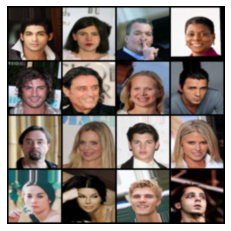

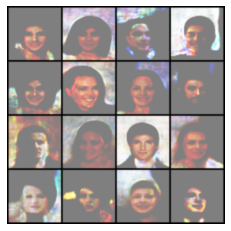

In [12]:
from torch.utils.data import RandomSampler
from torchvision.utils import save_image
import matplotlib.image as mpimg

with torch.no_grad():
  test_loader = DataLoader(celeba_data,batch_size=16, shuffle=True)
  itr = iter(test_loader)
  # next(itr)
  batch, _ = next(itr)
  batch = batch.to(device)
  model.eval()
  recon_batch, _, _  = model(batch)

  show(batch.cpu(), renorm = True, nrow=4)
  show(recon_batch.cpu(), renorm = True, nrow=4)


# epoch = 1
# n = 5

# comparison = torch.cat([batch[:n],recon_batch[:n]])

# save_image(comparison.cpu(),'reconstruction_ecommerce' + str(epoch) + '.png', nrow=n)
                
# plt.imshow(mpimg.imread('reconstruction_ecommerce' + str(epoch) + '.png'), aspect=True)


torch.Size([16, 12288])


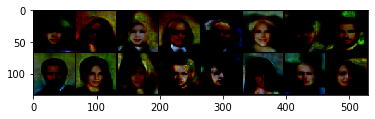

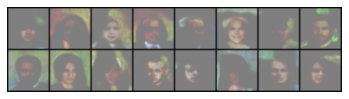

In [13]:
with torch.no_grad():
    epoch = 1
    sample = torch.randn(16, 150).to(device)
    sample = model.decode(sample).cpu()
    print(sample.shape)
    sample = sample.view(16, 3, 64, 64)
    
    save_image(sample,
                'sample_' + str(epoch) + '.png')
    plt.imshow(mpimg.imread('sample_' + str(epoch) + '.png'))
    
    show(sample, renorm = True, nrow=8)

torch.Size([10, 3, 64, 64])


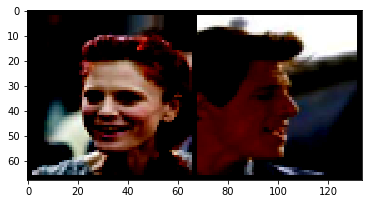

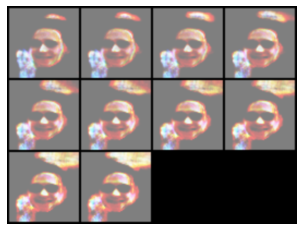

In [14]:
import numpy as np


def between(x_from, x_to):
  t_from, _ , _ = model.encode(x_from.view(-1, nc * ndf * ngf))
  t_to , _ , _ = model.encode(x_to.view(-1, nc * ndf * ngf))

  middle = torch.lerp(t_from, t_to, .5)

  return model.decode(middle)

def linear_interpolation(model, x_from, x_to, steps):
    n = steps

    t_from, _ , _ = model.encode(x_from.view(-1, nc * ndf * ngf))
    t_to , _ , _ = model.encode(x_to.view(-1, nc * ndf * ngf))

    t_from = t_from.cpu().detach().numpy()
    t_to = t_to.cpu().detach().numpy()

    diff = t_to - t_from
    inter = np.zeros((n, t_from.shape[1]))
    for i in range(n):
        inter[i] = t_from + np.linspace(0,1,steps)[i] * t_to

    inter = torch.tensor(inter).float().to(device)

    return model.decode(inter)


def plot_linear_interpolations(x_from, x_to, steps=10):
    batch = linear_interpolation(model, x_from, x_to, steps)
    batch = batch.view(-1, nc, ndf, ngf)
    print(batch.shape)
    show(batch.cpu(), renorm = True, nrow=4)

def show_single_image(img, name):
  save_image(img,
                'sample_' + name + '.png')
  plt.imshow(mpimg.imread('sample_' + name + '.png'))

with torch.no_grad():
  img1, _ = data_loader.dataset[1]
  img2, _  = data_loader.dataset[2]
  img1 = img1.to(device)
  img2 = img2.to(device)
  img1.unsqueeze_(0)
  img2.unsqueeze_(0)

  show_single_image(torch.cat((img1, img2)), "img1")
  
  plot_linear_interpolations(img1, img2)




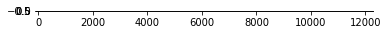

In [17]:
img3 = between(img1, img2)
show_single_image(img3, "img3")

In [0]:
#ignore utility function. remove it later on only relevent to cnn

def outputSize(in_size, kernel_size, stride, padding):
  output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
  return(output)

print(outputSize(32,4,2,0))